In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
from sklearn.utils import class_weight 
from sklearn import metrics

from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE

import yaml

In [4]:
with open("../../config.yaml", "r") as stream:
    try:
        configs = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [5]:
SEED                       = configs['SEED']
PATH_TO_TRAIN_DS_PROCESSED = str(configs['ROOT_DIR'] + configs['PATH_TO_TRAIN_DS_PROCESSED'])
PATH_TO_IMAGES             = str(configs['ROOT_DIR'] + configs['PATH_TO_IMAGES'])

'B:\\utils\\Documentos\\MDC\\projeto_final\\meme-sentiment-analysis/datasets/images/'

Parte 1: Treinando um modelo usando a RESNET

In [6]:
base = pd.read_csv(PATH_TO_TRAIN_DS_PROCESSED)
base.head()

,image_name,text,humour,sarcasm,offensive,motivational,target
0,image_1415.jpeg,if you want to view paradis simpli look around...,not_funny,not_sarcastic,not_offensive,motivational,positive
1,image_6460.png,if i had a brick for everi lie hillari told i ...,hilarious,general,very_offensive,motivational,positive
2,image_2303.png,that thing over there can i eat that,very_funny,general,not_offensive,motivational,very_positive
3,image_2417.png,my dad point to liam and said when did david b...,not_funny,general,very_offensive,motivational,neutral
4,image_11.jpg,probabl the first man to do year challeng chen...,funny,general,very_offensive,motivational,negative


In [10]:
base_train_val = base.copy().drop(['text', 'humour', 'sarcasm', 'offensive', 'motivational'], axis = 1)
base_train_val.target.replace("very_positive", 
           "positive", 
           inplace=True)
base_train_val.target.replace("very_negative", 
           "negative", 
           inplace=True)   
base_train_val['num_target'] = base_train_val.target.astype('category').cat.codes    
base_train_val.head()

,image_name,target,num_target
0,image_1415.jpeg,positive,2
1,image_6460.png,positive,2
2,image_2303.png,positive,2
3,image_2417.png,neutral,1
4,image_11.jpg,negative,0


In [11]:
train, val = train_test_split(base_train_val, test_size=0.2, random_state=SEED)
train.head()

,image_name,target,num_target
4223,image_2733.jpg,positive,2
1202,image_5768.jpg,negative,0
3262,image_5614.png,positive,2
4683,image_5449.png,positive,2
2600,image_1877.jpg,positive,2


In [28]:
#Carregando imagens do treino
width = 100
height = 100
X_train = []
X_train_path = []
for i in tqdm(train['image_name']):
    path = PATH_TO_IMAGES + i
    img = image.load_img(path,target_size=(width,height,3))
    img = image.img_to_array(img)
    # img = img/255.0
    X_train.append(img)
    X_train_path.append(path)

  6%|▌         | 267/4362 [00:09<02:34, 26.53it/s]d:\Programas\Python37\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 4362/4362 [02:36<00:00, 27.82it/s]


In [29]:
#Carregando imagens da validação
width = 100
height = 100
X_val = []
X_val_path = []
for i in tqdm(val['image_name']):
    path = PATH_TO_IMAGES + i
    img = image.load_img(path,target_size=(width,height,3))
    img = image.img_to_array(img)
    # img = img/255.0
    X_val.append(img)
    X_val_path.append(path)

100%|██████████| 1091/1091 [00:38<00:00, 28.41it/s]


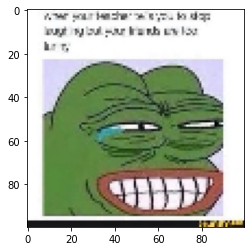

In [30]:
#Exemplo de imagem após carregar
plt.imshow(image.img_to_array(img)/255)

In [31]:
#Algumas transformações
X_train      = np.array(X_train)
X_val        = np.array(X_val)
Y_train      = train.target
Y_train_code = train.num_target
Y_val        = val.target
Y_val_code   = val.num_target
n_classes    = len(train.target.unique())
# Y_train_oh = np.array(pd.get_dummies(Y_train))
# Y_val_oh = np.array(pd.get_dummies(Y_val))
# Y_train = tf.keras.utils.to_categorical(Y_train_oh, n_classes)
# Y_val = tf.keras.utils.to_categorical(Y_val_oh, n_classes)


In [32]:
#Criando o gerador para as transformações
#Aqui, após alguns testes, encontrei que as melhores aumentações são a mudança de brilho e mudanças nos canais da imagem.
#Faz sentido pq elas não descaracterizam o meme.

datagen_resnet = ImageDataGenerator(brightness_range=[0.7,1.5],preprocessing_function=tf.keras.applications.resnet50.preprocess_input,channel_shift_range=20)
# datagen_resnet = ImageDataGenerator(zoom_range=0.2,horizontal_flip=True)
gerador_batches_resnet = datagen_resnet.flow(X_train, Y_train, shuffle=False, batch_size=64)

In [33]:
#Função para visualizar as imagens
def plotImages(imgList, n_row=1, n_col=1):
    _, axs = plt.subplots(n_row, n_col, figsize=(3, 3))
    axs = axs.flatten()
    for img, ax in zip(imgList, axs):
        ax.imshow(img.astype('float64'), interpolation='nearest')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imagens com aumentações + pré-processamento resnet


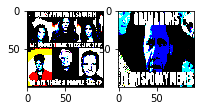

In [34]:
#Plotando alguns exemplos
batch_X_proc, batch_Y_proc = gerador_batches_resnet.next()
print("imagens com aumentações + pré-processamento resnet")
plotImages(batch_X_proc[:2], 1, 2)

In [35]:
#Isso aqui foi necessário para o callback:
tf.keras.backend.clear_session() 

# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
baseline_img = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(100,100,3))
baseline_img.summary()

# Congela camadas pré-treinadas exceto as últimas (o resultado não ficou bom congelando todas)
for layer in baseline_img.layers[:-4]:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
frozen_model = tf.keras.Sequential([
  baseline_img,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

frozen_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']      

In [36]:
cross = tf.keras.metrics.SparseCategoricalCrossentropy()

In [37]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001)
# Batches de treino e validação
train_batches = datagen_resnet.flow(X_train, np.array(Y_train_code), shuffle=False, batch_size=64)
val_batches = datagen_resnet.flow(X_val, np.array(Y_val_code), shuffle=False, batch_size=64)

class_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(Y_train) ,y = Y_train)
train_class_weights = dict(enumerate(class_weights))

# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_crossentropy', patience=25, restore_best_weights=True, mode='min')

frozen_model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=cross)

frozen_model.fit(train_batches, epochs=50,class_weight=train_class_weights, callbacks=[early],validation_data=val_batches)

Epoch 1/50
69/69 [==============================] - 83s 1s/step - loss: 1.3823 - sparse_categorical_crossentropy: 1.3819 - val_loss: 1.4467 - val_sparse_categorical_crossentropy: 1.4467
Epoch 2/50
69/69 [==============================] - 79s 1s/step - loss: 1.1277 - sparse_categorical_crossentropy: 1.1509 - val_loss: 1.5445 - val_sparse_categorical_crossentropy: 1.5445
Epoch 3/50
69/69 [==============================] - 82s 1s/step - loss: 0.9869 - sparse_categorical_crossentropy: 1.0232 - val_loss: 1.1541 - val_sparse_categorical_crossentropy: 1.1541
Epoch 4/50
69/69 [==============================] - 82s 1s/step - loss: 0.8970 - sparse_categorical_crossentropy: 0.9450 - val_loss: 1.1884 - val_sparse_categorical_crossentropy: 1.1884
Epoch 5/50
69/69 [==============================] - 84s 1s/step - loss: 0.8342 - sparse_categorical_crossentropy: 0.9001 - val_loss: 1.3773 - val_sparse_categorical_crossentropy: 1.3773
Epoch 6/50
69/69 [==============================] - 85s 1s/step - loss

In [38]:
val_frozen_model = frozen_model.predict(val_batches)

In [39]:
metrics.f1_score(val_batches.y,val_frozen_model.argmax(axis=-1),average='macro')

0.2992372266887972

In [40]:
metrics.balanced_accuracy_score(val_batches.y,  val_frozen_model.argmax(axis=-1))

0.2995561287433596

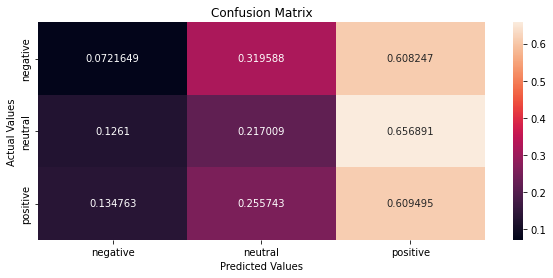

In [41]:
labels = ['negative', 'neutral', 'positive']
cm = metrics.confusion_matrix(val_batches.y,val_frozen_model.argmax(axis=-1))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = labels, 
                     columns = labels
                     )

plt.figure(figsize=(10,4))
sns.heatmap(cm_df, annot=True ,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Parte 2: Extração de features (para utilizar no modelo combinado) e visualização

In [42]:
for layer in baseline_img.layers:
    layer.trainable = False

frozen_model = tf.keras.Sequential([
  baseline_img,
  tf.keras.layers.GlobalAveragePooling2D()
])

feats_train = frozen_model.predict(X_train)
feats_val = frozen_model.predict(X_val)

In [43]:
tsnefeatures = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(feats_train)

In [44]:
np.unique(Y_train,return_counts=True)

(array(['negative', 'neutral', 'positive'], dtype=object),
 array([ 405, 1359, 2598], dtype=int64))

d:\Programas\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

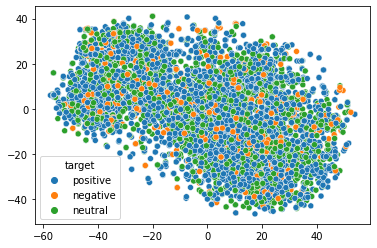

In [45]:
sns.scatterplot(tsnefeatures[:,0],tsnefeatures[:,1],hue=Y_train)